In [1]:
import numpy as np
import pandas as pd

from scipy import stats

from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Causal Secrets Mini-Course
## Secret 2 - Lecture 2

This notebook is a part of the [Causal Secrets Mini-Course](https://causalsecrets.com/).

<a href="https://causalpython.io"><img src="img/CausalPython.io - Dark.png" width=150 align="left"></a>

<br><br>

<img src="img/drug-A-vs-drug-B.jpg" width=600 align="center">

In this notebook, we'll test two drugs: A and B using a randomized controlled trial.

If there's no difference between the drugs in the population, does it matter which drug we'll prescribe to someone like Jennifer?

## Define the SCM

Let's define the data generating process.

In [2]:
class SCM:
    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.gene_1_variant = stats.multinomial(1, [.15, .5, .35])
        self.gene_2_variant = stats.multinomial(1, [.35, .5, .15])
        self.gene_expression_list = np.array([-1, 0, 1])
        self.treatment_dict = {
            0: 'control',
            1: 'drug A',
            2: 'drug B'
        }
        
    def get_counterfactuals(self, u_g1=None, u_g2=None, sample_size=100):
        
        if self.random_seed is not None:
            np.random.seed(self.random_seed)
            
        # Get individual level characteristics
        if u_g1 is None:
            u_g1 = self.gene_expression_list[
                np.argmax(
                    self.gene_1_variant.rvs(sample_size),
                    axis=1)
            ]
        else:
            u_g1 = np.array([u_g1]*sample_size)
        
        if u_g2 is None:
            u_g2 = self.gene_expression_list[
                np.argmax(
                    self.gene_2_variant.rvs(sample_size),
                    axis=1)
            ]
        else:
            u_g2 = np.array([u_g2]*sample_size)
        
        # Get treatment effects: treatment{d1, d2} X gene{g1, g2}
        y0 = np.full_like(u_g1, 0*u_g1 + 0*u_g2)
        y1 = 1*u_g1 + 0*u_g2
        y2 = 0*u_g1 - 1*u_g2
        
        self.counterfactual_data = pd.DataFrame(
            {
                'u_g1': u_g1,
                'u_g2': u_g2,
                'y0': y0,
                'y1': y1,
                'y2': y2
            }
        )
        
        return self.counterfactual_data
    
    def run_rct(self, sample_size=100):
        # Get counterfactuals
        self.get_counterfactuals(sample_size=sample_size)
        
        # Randomize the treatment & get the RCT data
        treatment_assignment = np.random.choice(3, sample_size)
        outcome_data = self.counterfactual_data[['y0', 'y1', 'y2']].values
        y_rct = outcome_data[np.arange(outcome_data.shape[0]), treatment_assignment]
        treatments = [self.treatment_dict[i] for i in treatment_assignment]
        
        # Construct the return object
        rct_data = pd.DataFrame(
            {
                'treatment': treatments,
                'y': y_rct
            }
        )
        
        return rct_data

## Run an RCT

Let's run a randomized experiment and examine the average outcomes

In [3]:
# Instantiate the SCM
scm = SCM(random_seed=42)

# Run an RCT
N = 1_000
rct_data = scm.run_rct(N)

# Compute means
rct_data.groupby('treatment').mean()

,y
treatment,
control,0.000000
drug A,0.244118
drug B,0.233918


## Analyze the Results

Let's analyze the results of our RCT

### Visual Analysis

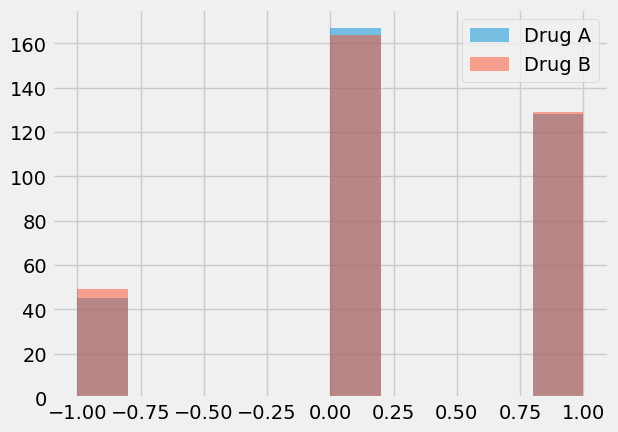

In [4]:
plt.hist(
    rct_data.query('treatment=="drug A"')['y'],
    alpha=.5,
    label='Drug A',
)

plt.hist(
    rct_data.query('treatment=="drug B"')['y'],
    alpha=.5,
    label='Drug B',
)

plt.legend()
plt.show()

In [5]:
# Filter out the control group (control outcome is always 0 by design)
rct_df_filtered = rct_data[rct_data['treatment'] != 'control']

# Build the contingency table: rows = treatment groups, columns = outcomes (-1, 0, 1)
contingency_table = pd.crosstab(rct_df_filtered['treatment'], rct_df_filtered['y'])
contingency_table

y,-1,0,1
treatment,,,
drug A,45,167,128
drug B,49,164,129


### $\chi^2$ Test

In [6]:
# Run the chi-square test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
print("\nChi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("p-value:", p)


Chi-square statistic: 0.19543072690444463
Degrees of freedom: 2
p-value: 0.9069070058988411


## Analyze Individual Conuterfactual Outcomes

Let's analyze the individual counterfactual outcomes and see what would be the outcomes of individual decisions.

In [7]:
outcome_dict = {
    -1: '\033[1;31mdie\033[0m',
    0: '\033[1;33mexperience no change\033[0m',
    1: '\033[1;32mrecover\033[0m'
}

In [8]:
cfs = scm.get_counterfactuals(u_g1=1, u_g2=1, sample_size=1)
cfs
print(f'Our patient would:\
     \n    - {outcome_dict[cfs["y0"][0]]} under no treatment\
     \n    - {outcome_dict[cfs["y1"][0]]} under treatment 1 (drug A)\
     \n    - {outcome_dict[cfs["y2"][0]]} under treatment 2 (drug B)')

Our patient would:     
    - experience no change under no treatment     
    - recover under treatment 1 (drug A)     
    - die under treatment 2 (drug B)


In [9]:
# See all combinations
combs = [
    (-1, -1),
    (-1, 0),
    (-1, 1), 
    (0, 0),
    (0, -1),
    (0, 1),
    (1, 1),
    (1, -1),
    (1, 0)
]

for c in combs:
    # Get the result from SCM1 & SCM2
    cfs = scm.get_counterfactuals(u_g1=c[0], u_g2=c[1], sample_size=1)
    
    print(f'A person with u1={c[0]} and u2={c[1]} would:\
         \n    - {outcome_dict[cfs["y1"][0]]} under treatment 1 (drug 1)\
         \n    - {outcome_dict[cfs["y2"][0]]} under treatment 2 (drug 2)\n\n')

A person with u1=-1 and u2=-1 would:         
    - die under treatment 1 (drug 1)         
    - recover under treatment 2 (drug 2)


A person with u1=-1 and u2=0 would:         
    - die under treatment 1 (drug 1)         
    - experience no change under treatment 2 (drug 2)


A person with u1=-1 and u2=1 would:         
    - die under treatment 1 (drug 1)         
    - die under treatment 2 (drug 2)


A person with u1=0 and u2=0 would:         
    - experience no change under treatment 1 (drug 1)         
    - experience no change under treatment 2 (drug 2)


A person with u1=0 and u2=-1 would:         
    - experience no change under treatment 1 (drug 1)         
    - recover under treatment 2 (drug 2)


A person with u1=0 and u2=1 would:         
    - experience no change under treatment 1 (drug 1)         
    - die under treatment 2 (drug 2)


A person with u1=1 and u2=1 would:         
    - recover under treatment 1 (drug 1)         
    - die under treatment 2 (drug 

## More Examples

See Example 9 in [Bareinboim et al (2021)](https://causalai.net/r60.pdf) for a more complex setup where two different SCMs lead to exactly the same experimental distributions.

<img src='img/neil-degrasse-tyson.jpg' width=200>

Another way in which experiments might not reveal important aspects of the underlying data generating process is when we only test certain values of the treatment or values in a certain range.

As nicely summarized by American astrophysicist and writer, Neil deGrasse Tyson, ["we went to the moon using Newton's laws, not Einstein's"](https://www.youtube.com/watch?v=y8-82Bpjdgk).

Newton's laws work well, unless we meet high speed and high gravity regimes, when they break down.